In [1]:
import torch.nn.functional as F
from torch import nn
import torch
import os
import cv2
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import json
from unet import UNetModel
from torch.optim import Adam

In [3]:
# fix gdown
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
def plot_9(imgs, labels=None, filename=None):
    imgs = [to_uint8(img) for img in imgs]
    if labels is None:
        labels = [None for i in range(len(imgs))]
    plt.figure(figsize=(10, 10))
    imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = imgs[i]
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis("off")
    if filename is not None:
        plt.savefig(filename)
        plt.close()

def normalise(img):
    img = np.float32(img)
    img -= np.min(img)
    img /= np.max(img)
    img = img*2 - 1
    return img

def import_images_from_folder(folder_path, num=5000):
    imgs = []
    for relative_img_path in os.listdir(folder_path)[:num]:
        if relative_img_path.endswith('.jpg'):
            try:
              img = cv2.imread(folder_path + relative_img_path)
              if img is not None:
                imgs.append(img)
                if len(imgs) == num:
                  break
            except:
              print('error occured with: ', relative_img_path)
    print('Imported '+str(len(imgs))+' images.')
    return imgs

def to_uint8(img):
    return np.uint8((img + 1) * 127.5)

def render(imgs, filename):
    cv2.imwrite('./view/'+filename, np.concatenate(imgs, axis=1))

def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def norm_and_resize_with_padding(img, size):
    size_max = np.max(img.shape)
    r = size/size_max
    img = cv2.resize(img, (int(round(img.shape[1]*r)), int(round(img.shape[0]*r))))
    img = normalise(img)
    offset_height = (size - img.shape[0])//2
    offset_width = (size - img.shape[1])//2
    canvas = np.float32(-np.ones((size,size,3)))
    canvas[offset_height : offset_height + img.shape[0], offset_width : offset_width + img.shape[1]] = img
    return canvas

In [3]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [ ]:
# faces
!gdown 1vEES1-EL4Ct9Q_kEwXry3NKMQ2tsc-qC

# vegetables
!gdown 1pFcVXGpjKt8233h54gkUEyh1djTMWGpS

# cars
!gdown 1af0QJcTzhvPYKj1E2c-WQkhn4ehg8BLl

# ill leaves
!gdown 1wFp1UUntJRvR0uqjpSv5Zu5GoGVhC9DP

# flowers
!gdown 1BKNtOOiWSWwm3H1fDp1W72BXxIepRkAv

# playing cards
!gdown 1b8lCjPZtolXgkm8CLgL54NFFptz4vqXL

In [3]:
# faces
!gdown 1vEES1-EL4Ct9Q_kEwXry3NKMQ2tsc-qC

Downloading...
From: https://drive.google.com/uc?id=1vEES1-EL4Ct9Q_kEwXry3NKMQ2tsc-qC
To: /content/faces.zip
100% 163M/163M [00:00<00:00, 240MB/s]


In [ ]:
!unzip faces.zip

In [72]:
img_dir = "./faces/"
size = 64
     
# import dataset
images = import_images_from_folder(img_dir)

# preprocess whole dataset
images = [norm_and_resize_with_padding(img, size=size) for img in images]

Imported 5000 images.


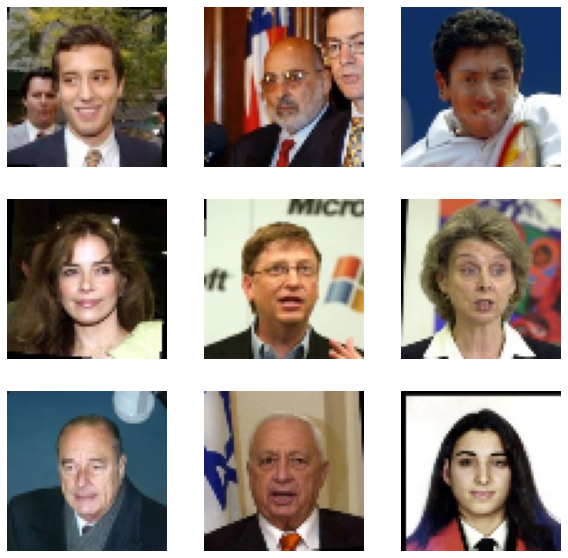

In [5]:
# plot 9 preprocessed imgs
plot_9(images[:9])

In [73]:
# build torch tensor
images = np.float32(images)
images = np.transpose(images, (0, 3, 1, 2))
images = torch.Tensor(images)

In [74]:
# PyTorch Dataset Objekt
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, steps_per_epoch, images):
        'Initialization'
        self.images = images
        self.steps_per_epoch = steps_per_epoch

    def __len__(self):
        'Denotes the total number of samples'
        return self.steps_per_epoch

    def __getitem__(self, index):
        'Generates one sample of data'
        index = np.random.choice(len(self.images))
        return self.images[index]

In [75]:
batch_size = 8
Sampler = MyDataset(1000, images)
train_loader = DataLoader(
    Sampler,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2)

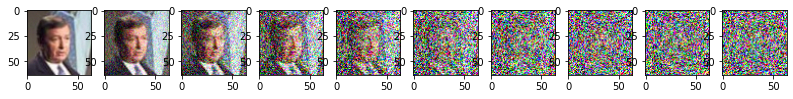

In [85]:
# Simulate forward diffusion
def show_tensor_image(image, filename=None):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: np.clip(t, 0, 255)),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    image = np.flip(reverse_transforms(image), 2)
    if filename is not None:
        cv2.imwrite(filename, image)
    plt.imshow(image)

image = next(iter(train_loader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int((idx/stepsize) + 1))
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

In [77]:
# args for Unet
image_size = size
in_channels = 3
model_channels = 32
out_channels = 3
num_res_blocks = 1
attention_resolutions = (32, 16, 8, 4)
dropout=0
channel_mult = (4, 5, 6, 7, 8)
conv_resample=True
dims=2
num_classes=None
use_checkpoint=False
use_fp16=False
num_heads=4
num_head_channels=16
num_heads_upsample=-1
use_scale_shift_norm=False
resblock_updown=False
use_new_attention_order=False

In [78]:
model = UNetModel(
    image_size, 
    in_channels, 
    model_channels, 
    out_channels, 
    num_res_blocks, 
    attention_resolutions, 
    dropout,
    channel_mult, 
    conv_resample, 
    dims, 
    num_classes, 
    use_checkpoint, 
    use_fp16, 
    num_heads, 
    num_head_channels, 
    num_heads_upsample)

print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  22402883


In [79]:
device = "cuda"
#model.load_state_dict(torch.load("unet.ckpt"))
model = model.to(device)

In [87]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    just_image = x[:,:3,:,:]
    model_mean = sqrt_recip_alphas_t * (
        just_image - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, just_image.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(just_image)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(filename):
    # Sample noise
    img = torch.randn((1, 3, size, size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in tqdm(range(0,T)[::-1]):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images+1, int(round(i/stepsize)+2))
            show_tensor_image(img.detach().cpu(), filename)

100%|██████████| 300/300 [00:07<00:00, 42.38it/s]


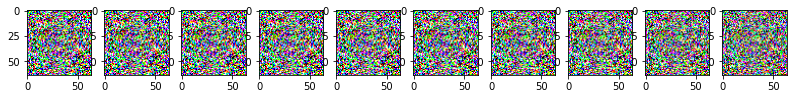

In [81]:
sample_plot_image()

In [82]:
opt = Adam(model.parameters(), lr=0.00002)

100%|██████████| 300/300 [00:07<00:00, 40.93it/s]
0.122: : 125it [00:19,  6.46it/s]


Epoch 0 | step 124 Loss: 0.17892148231546726 


100%|██████████| 300/300 [00:06<00:00, 43.05it/s]
0.145: : 47it [00:07,  6.26it/s]


KeyboardInterrupt: ignored

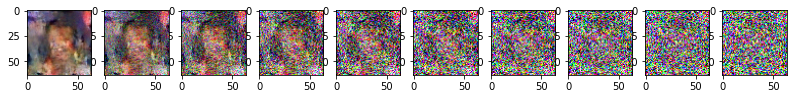

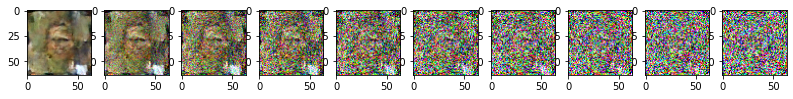

In [88]:
epochs = 10000 # Try more!

def train_step(opt, model, x_0, t):
    opt.zero_grad()
    loss = get_loss(model, x_0, t)
    loss.backward()
    opt.step()
    return loss

for epoch in range(epochs):
    sample_plot_image('./view/'+str(epoch)+'.jpg')
    pbar = tqdm(enumerate(train_loader))
    mean_loss = 0
    for step, batch in pbar:
        t = torch.randint(0, T, (batch_size,), device=device).long()
        batch = batch.to(device)
        loss = train_step(opt, model, batch, t)
        loss = loss.cpu().detach().numpy()
        mean_loss += loss
        pbar.set_description(str(loss)[:5])
    print(f"Epoch {epoch} | step {step:03d} Loss: {mean_loss/step} ")
    torch.save(model.state_dict(), 'unet.ckpt')

100%|██████████| 300/300 [00:06<00:00, 43.21it/s]


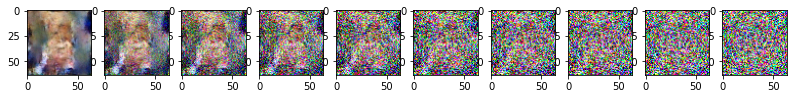

In [84]:
sample_plot_image()